In [1]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import cPickle as pickle
import gzip
from photutils import CircularAnnulus
from photutils import CircularAperture
from photutils import aperture_photometry


In [2]:
# SPIRE channels
lambdas = [250, 350, 500]
psf     = {250:17.8, 350:24.0, 500:35.2} # in arcsec 
factor  = {250:469./36., 350:831./64., 500:1804./144.} # Jy/beam -> Jy/pixel 
reso    = {250:6., 350:8., 500:12.} # in arcsec 
# positions = {250: (25.5, 25.5), 350: (19.5,19.5), 500:(13.5,13.5)}
# boxsize = {250:51, 350:39, 500:27}
boxsize    = {250:101, 350:77, 500:51} # SPIRE pixels are ~ 6/8/12 arcsec -> cutouts are 5'
positions = {250: (101/2., 101/2.), 350: (77/2.,77/2.), 500:(51/2.,51/2.)}

# H-ATLAS patches
patches = ['G9', 'G12', 'G15']#, 'NGP', 'SGP']

# Results folder
results_folder = 'results/'

zbins = [(1., 5.0)]
# zbins = [(0.1, 1.), (1.,2.), (2.,3.), (3.,4.)]#, (4.,5.)]

rmax = 9

In [74]:
bkd = {}
sims = {}
noise = {}
z ={} 
fluxes_bkd = {}

for lambda_ in lambdas:
    bkd[lambda_] = {}
    sims[lambda_] = {}
    noise[lambda_] = {}
    fluxes_bkd[lambda_] = {}
    z[lambda_] = {}
    # Loop over patches
    for patch in patches:
            bkd[lambda_][patch] = {}
            sims[lambda_][patch] = {}
            noise[lambda_][patch] = {}
            fluxes_bkd[lambda_][patch] = {}
            z[lambda_][patch] = {} 
            for idz, (zmin, zmax) in enumerate(zbins):
                sims_ = pickle.load(gzip.open(results_folder + '/patch'+patch+'_lambda'+str(lambda_)+'_zmin'+str(zmin)+'_zmax'+str(zmax)+'_10arcmin.pkl','rb'))
                sims[lambda_][patch][idz] = np.asarray(sims_['maps'])
                noise[lambda_][patch][idz] = np.asarray(sims_['noise'])
                bkd_ = pickle.load(gzip.open(results_folder + '/patch'+patch+'_lambda'+str(lambda_)+'_zmin'+str(zmin)+'_zmax'+str(zmax)+'_RND_10arcmin.pkl','rb'))
                bkd[lambda_][patch][idz] = bkd_['maps']
                fluxes_bkd[lambda_][patch][idz] = bkd_['fluxes']
                z[lambda_][patch][idz] = sims_['z']
                print lambda_, patch, bkd_['nrnd_']

250 G9 27345
250 G12 27741
250 G15 27551
350 G9 26943
350 G12 27224
350 G15 27635
500 G9 26949
500 G12 27158
500 G15 27358


In [32]:
def GetTotPhotometryFromStacks(lambda_, zbin, r, r_in=None, r_out=None, remove_mean=True, remove_max=False):
    simuls = {}
    for patch in patches:
        simuls[patch] = sims[lambda_][patch][zbin].copy()
        
    if remove_max > 0:
        for patch in patches:
            for _ in xrange(remove_max):
                simuls[patch] = np.delete(simuls[patch], np.argmax(np.mean(simuls[patch], axis=(1,2))), axis=0)

#     print lambda_, zbin, r, np.concatenate([simuls[patch].copy() - bkd[lambda_][patch][zbin].mean() for patch in patches], axis=0).shape
    
    if (r_in is None) or (r_out is None):
        apertures = CircularAperture(positions[lambda_], r=r)
        if remove_mean:
            stacked_map = np.concatenate([simuls[patch].copy() - bkd[lambda_][patch][zbin].mean() for patch in patches], axis=0).mean(0)
#           stacked_map = (simuls.mean(axis=0) - bkd[lambda_][patch].mean())
        else:
#             stacked_map = simuls.mean(axis=0)
            stacked_map = np.concatenate([simuls[patch].copy() for patch in patches], axis=0).mean(0)

        phot_table = aperture_photometry(stacked_map/(factor[lambda_])/1e-3, apertures)
    else:
        apertures = CircularAperture(positions[lambda_], r=r)
        annulus_apertures = CircularAnnulus(positions[lambda_], r_in=r_in, r_out=r_out)
        apers = [apertures, annulus_apertures]
        if remove_mean:
            stacked_map = np.concatenate([simuls[patch].copy() - bkd[lambda_][patch][zbin].mean() for patch in patches], axis=0).mean(0)
        else:
            stacked_map = np.concatenate([simuls[patch].copy() for patch in patches], axis=0).mean(0)
        phot_table = aperture_photometry(stacked_map/(factor[lambda_])/1e-3, apers)  
        bkg_mean = phot_table['aperture_sum_1'] / annulus_apertures.area()
        bkg_sum = bkg_mean * apertures.area()
        final_sum = phot_table['aperture_sum_0'] - bkg_sum
        phot_table['aperture_sum'] = final_sum
    
    return phot_table.field('aperture_sum')[0]

120.0
160.0
240.0


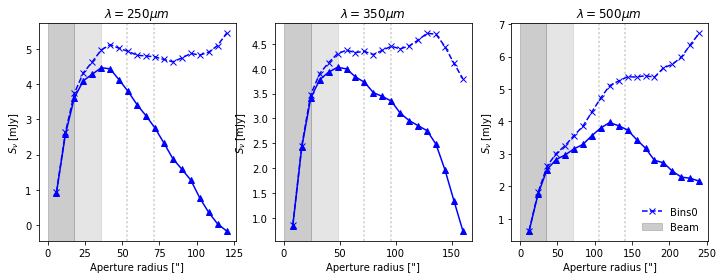

In [33]:
ph_mean = []
ph_mean2 = []

rmax = 20

cols = {0:'b', 1:'r', 2:'g', 3:'y', 4:'k', 5:'c'}
j=1
fig = plt.figure(figsize=(12,4))
for lambda_ in lambdas:
    plt.subplot(1,3,j)
    plt.title(r'$\lambda=%d \mu m$ ' %lambda_)
    print rmax*reso[lambda_]
    
    for idz in xrange(len(zbins)):
        for i in xrange(1,rmax+1):
            ph_mean.append(GetTotPhotometryFromStacks(lambda_, idz, i, r_in=7*psf[lambda_]/reso[lambda_], r_out=9*psf[lambda_]/reso[lambda_], remove_mean=False, remove_max=15))
            ph_mean2.append(GetTotPhotometryFromStacks(lambda_, idz, i, remove_mean=True, remove_max=15))
        
        plt.plot(reso[lambda_]*np.arange(1,rmax+1), ph_mean,'--x', label='Bins' + str(idz), color=cols[idz])
        plt.plot(reso[lambda_]*np.arange(1,rmax+1), ph_mean2,'-^', color=cols[idz])

        ph_mean = []
        ph_mean2 = []
              

    plt.axvspan(0, psf[lambda_], alpha=0.4, color='grey', label=r'Beam')
    plt.axvspan(psf[lambda_], 2*psf[lambda_], alpha=0.2, color='grey')
    plt.axvline(3*psf[lambda_], ls=':', alpha=0.2, color='k')
    plt.axvline(4*psf[lambda_], ls=':', alpha=0.2, color='k')
#     plt.ylim([0,12])
#     plt.xlim([0,100])
    plt.xlabel('Aperture radius ["]')
    plt.ylabel(r'$S_{\nu}$ [mJy]')
    j=j+1
plt.legend(loc='best',frameon=False)

In [31]:
print 'lambda', patch, 'N_obj'
for lambda_ in lambdas:
    for patch in patches:
        print lambda_, patch, sims[lambda_][patch][0].shape[0]

lambda G15 N_obj
250 G9 2452
250 G12 2358
250 G15 1981
350 G9 2440
350 G12 2352
350 G15 1991
500 G9 2416
500 G12 2311
500 G15 1973


77

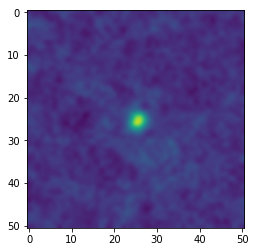

In [34]:
l = 500
# plt.subplot(121)
plt.imshow(np.concatenate([sims[l][patch][0].copy() - bkd[l][patch][0].mean() for patch in patches], axis=0).mean(0), interpolation='bicubic')
# plt.subplot(122)
# plt.imshow(np.concatenate([sims[l][patch][1].copy() - bkd[l][patch][1].mean() for patch in patches], axis=0).mean(0))

In [41]:
for i in xrange(1):
    print np.sum([sims[500][p][i].shape[0] for p in patches])

6700


250 6.0 8.48528137424
250 12.0 16.9705627485
250 18.0 25.4558441227
250 24.0 33.941125497
250 30.0 42.4264068712
250 36.0 50.9116882454
250 42.0 59.3969696197
250 48.0 67.8822509939
250 54.0 76.3675323681
250 60.0 84.8528137424
250 66.0 93.3380951166
250 72.0 101.823376491
250 78.0 110.308657865
250 84.0 118.793939239
350 8.0 11.313708499
350 16.0 22.627416998
350 24.0 33.941125497
350 32.0 45.2548339959
350 40.0 56.5685424949
350 48.0 67.8822509939
350 56.0 79.1959594929
350 64.0 90.5096679919
350 72.0 101.823376491
350 80.0 113.13708499
350 88.0 124.450793489
350 96.0 135.764501988
350 104.0 147.078210487
350 112.0 158.391918986
500 12.0 16.9705627485
500 24.0 33.941125497
500 36.0 50.9116882454
500 48.0 67.8822509939
500 60.0 84.8528137424
500 72.0 101.823376491
500 84.0 118.793939239
500 96.0 135.764501988
500 108.0 152.735064736
500 120.0 169.705627485
500 132.0 186.676190233
500 144.0 203.646752982
500 156.0 220.61731573
500 168.0 237.587878479


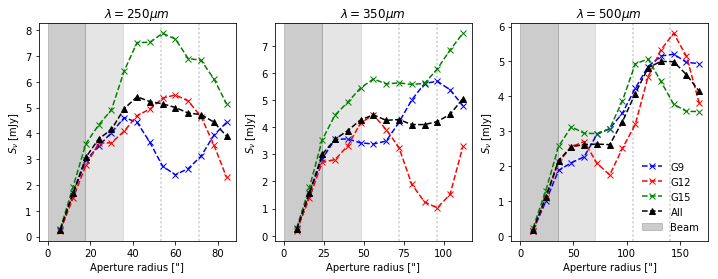

In [34]:
def GetPhotometryFromStacks(lambda_, zbin, patch, r, r_in=None, r_out=None, remove_mean=True, remove_max=0):
#     simuls = {}
#     simuls[patch] = sims[lambda_][patch][zbin].copy()
    simuls = sims[lambda_][patch][zbin].copy()

    if remove_max > 0:
        for _ in xrange(remove_max):
            simuls = np.delete(simuls, np.argmax(np.mean(simuls, axis=(1,2))), axis=0)
       
    if (r_in is None) or (r_out is None):
        apertures = CircularAperture(positions[lambda_], r=r)
        if remove_mean:
            stacked_map = (simuls.mean(axis=0) - bkd[lambda_][patch][zbin].mean())
        else:
            stacked_map = simuls.mean(axis=0)
        phot_table = aperture_photometry(stacked_map/(factor[lambda_])/1e-3, apertures)
    else:
        apertures = CircularAperture(positions[lambda_], r=r)
        annulus_apertures = CircularAnnulus(positions[lambda_], r_in=r_in, r_out=r_out)
        apers = [apertures, annulus_apertures]
        if remove_mean:
            stacked_map = (simuls.mean(axis=0) - bkd[lambda_][patch][zbin].mean())
        else:
            stacked_map = simuls.mean(axis=0)
        phot_table = aperture_photometry(stacked_map/(factor[lambda_])/1e-3, apers)  
        bkg_mean = phot_table['aperture_sum_1'] / annulus_apertures.area()
        bkg_sum = bkg_mean * apertures.area()
        final_sum = phot_table['aperture_sum_0'] - bkg_sum
        phot_table['aperture_sum'] = final_sum
    return phot_table.field('aperture_sum')[0]

ph_mean = []
ph_mean2 = []
cols = {'G9':'b', 'G12':'r', 'G15':'g'}
j=1
zbin = 0
rmax=14

fig = plt.figure(figsize=(12,4))
for lambda_ in lambdas:
    plt.subplot(1,3,j)
    plt.title(r'$\lambda=%d \mu m$ ' %lambda_)
    
    for patch in patches:
        for i in xrange(1,rmax+1):
            ph_mean.append(GetPhotometryFromStacks(lambda_, zbin, patch, i, r_in=i, r_out=i*np.sqrt(2), remove_mean=False, remove_max=15))
#             ph_mean.append(GetPhotometryFromStacks(lambda_, zbin, patch, i, r_in=7*psf[lambda_]/reso[lambda_], r_out=9*psf[lambda_]/reso[lambda_], remove_mean=False, remove_max=10))
        plt.plot(reso[lambda_]*np.arange(1,rmax+1), ph_mean,'--x', label=patch, color=cols[patch])
        ph_mean = []
        ph_mean2 = []
          
    for i in xrange(1,rmax+1):
        print lambda_, i*reso[lambda_], i*2**0.5*reso[lambda_]
        ph_mean2.append(GetTotPhotometryFromStacks(lambda_, zbin, i, r_in=i, r_out=i*np.sqrt(2), remove_mean=False, remove_max=15))
#         ph_mean2.append(GetTotPhotometryFromStacks(lambda_, zbin, i, r_in=7*psf[lambda_]/reso[lambda_], r_out=9*psf[lambda_]/reso[lambda_], remove_mean=False, remove_max=10))
    
    plt.plot(reso[lambda_]*np.arange(1,rmax+1), ph_mean2,'--^', label='All', color='k')

    plt.axvspan(0, psf[lambda_], alpha=0.4, color='grey', label=r'Beam')
    plt.axvspan(psf[lambda_], 2*psf[lambda_], alpha=0.2, color='grey')
    plt.axvline(3*psf[lambda_], ls=':', alpha=0.2, color='k')
    plt.axvline(4*psf[lambda_], ls=':', alpha=0.2, color='k')
#     plt.ylim([0,12])
#     plt.xlim([0,100])
    plt.xlabel('Aperture radius ["]')
    plt.ylabel(r'$S_{\nu}$ [mJy]')
    j=j+1
plt.legend(loc='best',frameon=False)
    

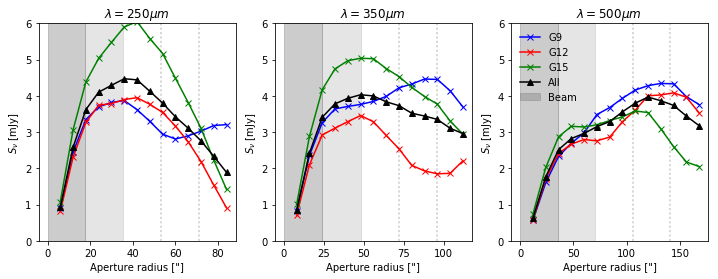

In [35]:
ph_mean = []
ph_mean2 = []
cols = {'G9':'b', 'G12':'r', 'G15':'g'}
j=1
zbin = 0
rmax = 14

fig = plt.figure(figsize=(12,4))
for lambda_ in lambdas:
    plt.subplot(1,3,j)
    plt.title(r'$\lambda=%d \mu m$ ' %lambda_)
    
    for patch in patches:
        for i in xrange(1,rmax+1):
            ph_mean.append(GetPhotometryFromStacks(lambda_, zbin, patch, i, remove_mean=True, remove_max=15))
        plt.plot(reso[lambda_]*np.arange(1,rmax+1), ph_mean,'-x', label=patch, color=cols[patch])
        ph_mean = []
        ph_mean2 = []
          
    for i in xrange(1,rmax+1):
        ph_mean2.append(GetTotPhotometryFromStacks(lambda_, zbin, i, remove_mean=True, remove_max=15))
    
    plt.plot(reso[lambda_]*np.arange(1,rmax+1), ph_mean2,'-^', label='All', color='k')

    plt.axvspan(0, psf[lambda_], alpha=0.4, color='grey', label=r'Beam')
    plt.axvspan(psf[lambda_], 2*psf[lambda_], alpha=0.2, color='grey')
    plt.axvline(3*psf[lambda_], ls=':', alpha=0.2, color='k')
    plt.axvline(4*psf[lambda_], ls=':', alpha=0.2, color='k')
    plt.ylim([0,6])
#     plt.xlim([0,100])
    plt.xlabel('Aperture radius ["]')
    plt.ylabel(r'$S_{\nu}$ [mJy]')
    j=j+1
plt.legend(loc='best',frameon=False)

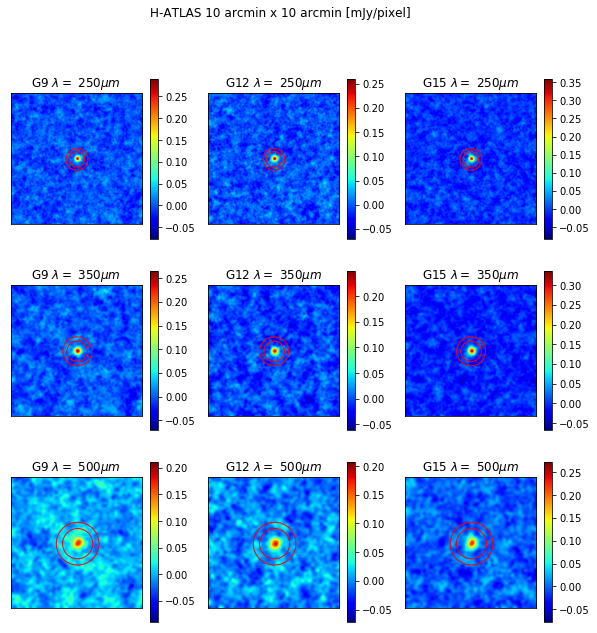

In [26]:
def do_thumbnails_plot(remove_max=0):
    fig = plt.figure(figsize=(10,10))
    i=1
    plt.suptitle('H-ATLAS 10 arcmin x 10 arcmin [mJy/pixel]')
    for lambda_ in lambdas:
        for patch in patches:
#             plt.subplot(3,3,i)
            ax = fig.add_subplot(3, 3, i)
            plt.title(patch + r' $\lambda= $ ' +str(lambda_) + r'$\mu m$')
            simuls = sims[lambda_][patch][0].copy()
#             if remove_max != 0:
#                 i = 0
#                 while i <= remove_max:
#                     simuls = np.delete(simuls, np.argmax(np.mean(simuls, axis=(1,2))), axis=0)
#                     i += 1
            simuls = np.delete(simuls, np.argmax(np.mean(simuls, axis=(1,2))), axis=0)
            simuls = np.delete(simuls, np.argmax(np.mean(simuls, axis=(1,2))), axis=0)
            simuls = np.delete(simuls, np.argmax(np.mean(simuls, axis=(1,2))), axis=0)
            simuls = np.delete(simuls, np.argmax(np.mean(simuls, axis=(1,2))), axis=0)
            simuls = np.delete(simuls, np.argmax(np.mean(simuls, axis=(1,2))), axis=0)
            simuls = np.delete(simuls, np.argmax(np.mean(simuls, axis=(1,2))), axis=0)
            simuls = np.delete(simuls, np.argmax(np.mean(simuls, axis=(1,2))), axis=0)
            simuls = np.delete(simuls, np.argmax(np.mean(simuls, axis=(1,2))), axis=0)
            simuls = np.delete(simuls, np.argmax(np.mean(simuls, axis=(1,2))), axis=0)
            simuls = np.delete(simuls, np.argmax(np.mean(simuls, axis=(1,2))), axis=0)
            simuls = np.delete(simuls, np.argmax(np.mean(simuls, axis=(1,2))), axis=0)
            simuls = np.delete(simuls, np.argmax(np.mean(simuls, axis=(1,2))), axis=0)
            simuls = np.delete(simuls, np.argmax(np.mean(simuls, axis=(1,2))), axis=0)
            simuls = np.delete(simuls, np.argmax(np.mean(simuls, axis=(1,2))), axis=0)
            simuls = np.delete(simuls, np.argmax(np.mean(simuls, axis=(1,2))), axis=0)
            simuls = np.delete(simuls, np.argmax(np.mean(simuls, axis=(1,2))), axis=0)
            simuls = np.delete(simuls, np.argmax(np.mean(simuls, axis=(1,2))), axis=0)
            simuls = np.delete(simuls, np.argmax(np.mean(simuls, axis=(1,2))), axis=0)
            simuls = np.delete(simuls, np.argmax(np.mean(simuls, axis=(1,2))), axis=0)
            simuls = np.delete(simuls, np.argmax(np.mean(simuls, axis=(1,2))), axis=0)
            simuls = np.delete(simuls, np.argmax(np.mean(simuls, axis=(1,2))), axis=0)

            simuls = simuls.mean(axis=0) - bkd[lambda_][patch][0].mean()
            plt.imshow(simuls/(factor[lambda_])/1e-3, interpolation='bicubic', cmap='jet')
            
            circin = plt.Circle(positions[lambda_], radius=2*psf[lambda_]/reso[lambda_], color='r', fill=False)
            circout = plt.Circle(positions[lambda_], radius=2*np.sqrt(2)*psf[lambda_]/reso[lambda_], color='r', fill=False)
#             ax.add_patch(circ)
            ax.add_patch(circin)
            ax.add_patch(circout)

            plt.colorbar()
#             plt.plot(positions[lambda_], 'w+', mew=2.)
            frame1 = plt.gca()
            frame1.axes.get_xaxis().set_visible(False)
            frame1.axes.get_yaxis().set_visible(False)
            i += 1
    plt.show()
    
do_thumbnails_plot()

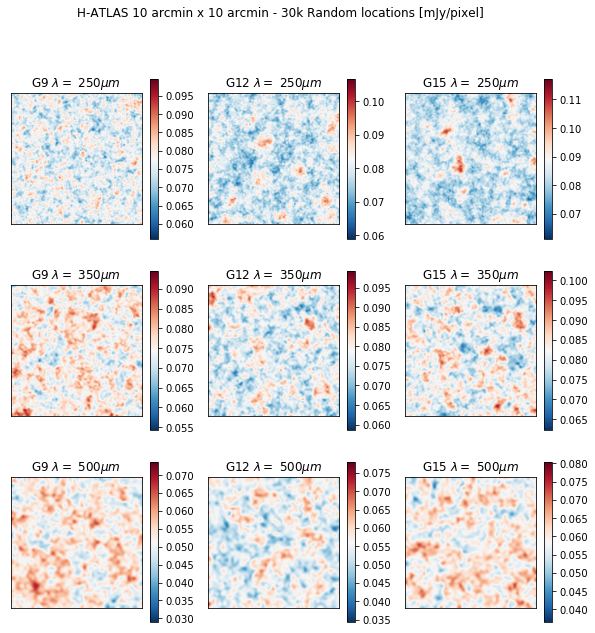

In [144]:
fig = plt.figure(figsize=(10,10))
i=1
plt.suptitle('H-ATLAS 10 arcmin x 10 arcmin - 30k Random locations [mJy/pixel]')
for lambda_ in lambdas:
    for patch in patches:
        plt.subplot(3,3,i)
        plt.title(patch + r' $\lambda= $ ' +str(lambda_) + r'$\mu m$')
        plt.imshow(bkd[lambda_][patch][0]/factor[lambda_]/1e-3, interpolation='bicubic', cmap='RdBu_r')
        plt.colorbar()
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_visible(False)
        frame1.axes.get_yaxis().set_visible(False)
        i += 1
plt.show()

In [59]:
def plot_slice(lambda_, patch, remove_max=True):
    simuls = sims[lambda_][patch][0].copy()
    if remove_max:
        print np.argmax(np.mean(simuls,axis=(1,2)))
        simuls = np.delete(simuls, np.argmax(np.mean(simuls, axis=(1,2))), axis=0)
        simuls = np.delete(simuls, np.argmax(np.mean(simuls, axis=(1,2))), axis=0)
        simuls = np.delete(simuls, np.argmax(np.mean(simuls, axis=(1,2))), axis=0)
        simuls = np.delete(simuls, np.argmax(np.mean(simuls, axis=(1,2))), axis=0)

    for i in xrange(boxsize[lambda_]):
        if i == 10:
            plt.plot(reso[lambda_]*(np.arange(boxsize[lambda_])-positions[lambda_][0]), (simuls.mean(axis=0)-bkd[lambda_][patch][0].mean())[i,:]/(factor[lambda_])/1e-3, color='blue', alpha=0.3, label='w/o background')
        else:
            plt.plot(reso[lambda_]*(np.arange(boxsize[lambda_])-positions[lambda_][0]), (simuls.mean(axis=0)-bkd[lambda_][patch][0].mean())[i,:]/(factor[lambda_])/1e-3, color='blue', alpha=0.5)#, label='w/ background')

    for i in xrange(boxsize[lambda_]):
        if i == 10:
            
            plt.plot(reso[lambda_]*(np.arange(boxsize[lambda_])-positions[lambda_][0]), (simuls.mean(axis=0))[i,:]/(factor[lambda_])/1e-3, color='grey', alpha=0.2, label='w/ background')
        else:
            plt.plot(reso[lambda_]*(np.arange(boxsize[lambda_])-positions[lambda_][0]), (simuls.mean(axis=0))[i,:]/(factor[lambda_])/1e-3, color='grey', alpha=0.3)#, label='w/ background')
    plt.axhline(ls='--',lw=3, color='r')
    plt.axhline(bkd[lambda_][patch][0].mean()/(factor[lambda_])/1e-3, ls=':',lw=3, color='r')
    plt.title(str(lambda_) + r' $\mu$m' + patch)
    plt.legend(loc='best')
    plt.xlabel(r'$\Delta x$ [arcsec]')
    plt.ylabel(r'$S_{\nu}$ [mJy/pix]')
    plt.ylim([-0.05,0.4])
    plt.xlim([-5.*60.,5.*60])

292
1981
530
1728
1975
533
603
1939
1148


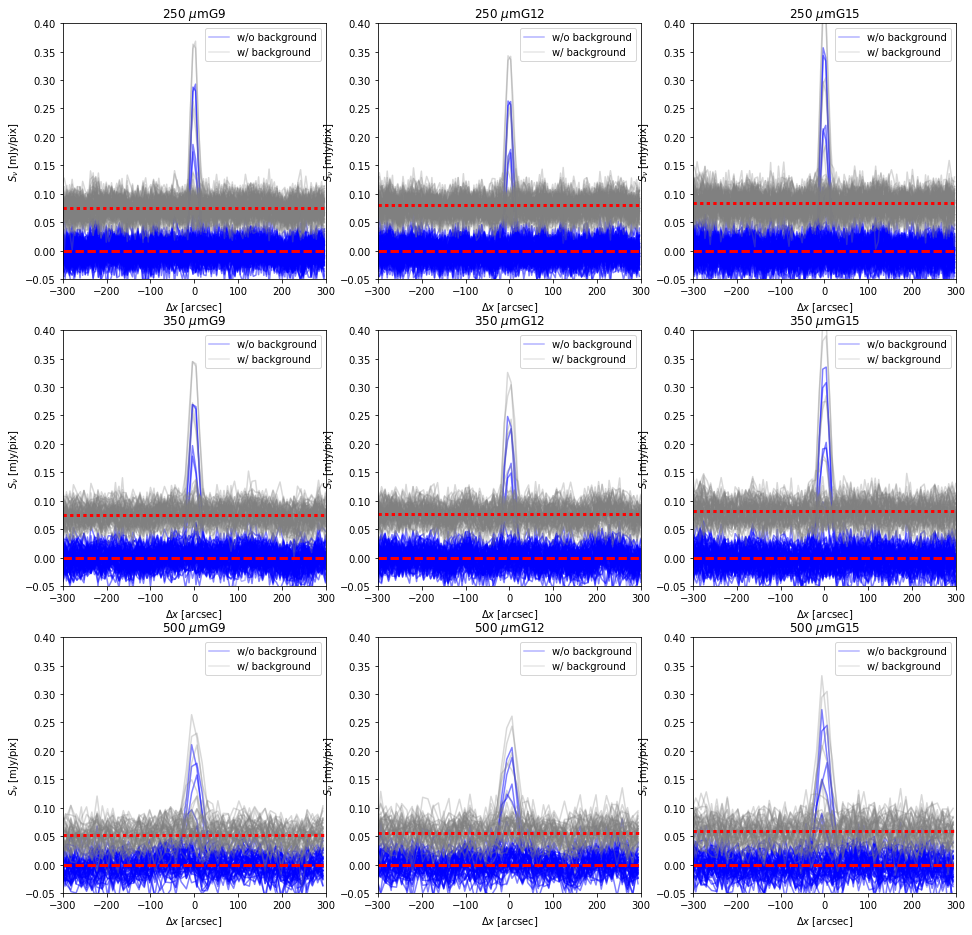

In [60]:
fig = plt.figure(figsize=(16,16))
j = 1
for lambda_ in lambdas:
    for patch in patches:
        plt.subplot(3,3,j)
        plot_slice(lambda_, patch)
        j+=1

In [38]:
z_ = {}
for lambda_ in lambdas:
    z_[lambda_] = np.concatenate([z[lambda_][patch][0] for patch in patches])

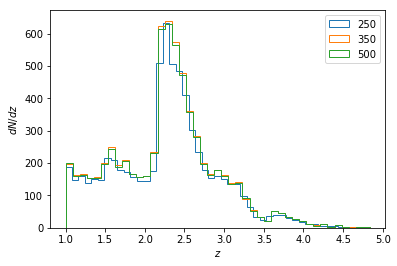

In [39]:
from astropy.visualization import hist
hist(z_[250], bins="knuth", histtype='step', label='250')
hist(z_[350], bins="knuth", histtype='step', label='350')
hist(z_[500], bins="knuth", histtype='step', label='500')
plt.xlabel(r'$z$')
plt.ylabel(r'$dN/dz$')
plt.legend()

In [42]:
print len(z_[250][z_[250] < 1.6])
print len(z_[250][(z_[250] >= 1.6) & (z_[250] < 2.15)])
print len(z_[250][(z_[250] >= 2.15) & (z_[250] < 2.3)])
print len(z_[250][(z_[250] >= 2.3) & (z_[250] < 2.5)])
print len(z_[250][(z_[250] >= 2.5) & (z_[250] < 2.9)])
print len(z_[250][(z_[250] >= 2.8) & (z_[250] < 5)])


1213
1139
1074
1193
1168
1197


In [48]:
print len(z_[250][z_[250] < 2.])
print len(z_[250][(z_[250] >= 2.) & (z_[250] < 2.3)])
print len(z_[250][(z_[250] >= 2.5) & (z_[250] < 5)])


2040
1386
2172


In [142]:
simuls = sims[250]['G9'][0].copy()
(simuls.mean(axis=0)-bkd[250]['G9'][0].mean())[51,51]*(factor[250])/1e-3

47.569974830063686

In [13]:
np.std(fluxes_bkd[250]['G12'][0])/np.sqrt(fluxes_bkd[250]['G12'][0].shape)

array([ 0.30602123])

In [50]:
for lambda_ in lambdas:
    for patch in patches:
        print lambda_, patch, np.std(fluxes_bkd[lambda_][patch][0])/np.sqrt(fluxes_bkd[lambda_][patch][0].shape)

250 G9 [ 0.14612942]
250 G12 [ 0.30602123]
250 G15 [ 0.19760448]
350 G9 [ 0.16219293]
350 G12 [ 0.17104015]
350 G15 [ 0.23755959]
500 G9 [ 0.15944807]
500 G12 [ 0.19295224]
500 G15 [ 0.1732007]


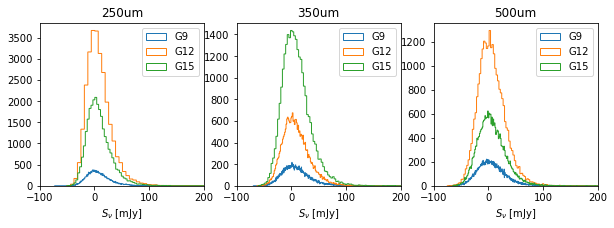

In [24]:
i=1
plt.figure(figsize=(10,3))
for lambda_ in lambdas:
    plt.subplot(1,3,i)
    plt.title(str(lambda_)+'um')
    for patch in patches:
        plt.hist(fluxes_bkd[lambda_][patch][0],1000, histtype='step', label=patch)
    plt.legend()
    plt.xlabel(r'$S_{\nu}$ [mJy]')
    plt.xlim([-100,200])
    i += 1

250 6.0 8.48528137424
250 12.0 16.9705627485
250 18.0 25.4558441227
250 24.0 33.941125497
250 30.0 42.4264068712
250 36.0 50.9116882454
250 42.0 59.3969696197
250 48.0 67.8822509939
250 54.0 76.3675323681
250 60.0 84.8528137424
250 66.0 93.3380951166
250 72.0 101.823376491
250 78.0 110.308657865
250 84.0 118.793939239
350 8.0 11.313708499
350 16.0 22.627416998
350 24.0 33.941125497
350 32.0 45.2548339959
350 40.0 56.5685424949
350 48.0 67.8822509939
350 56.0 79.1959594929
350 64.0 90.5096679919
350 72.0 101.823376491
350 80.0 113.13708499
350 88.0 124.450793489
350 96.0 135.764501988
350 104.0 147.078210487
350 112.0 158.391918986
500 12.0 16.9705627485
500 24.0 33.941125497
500 36.0 50.9116882454
500 48.0 67.8822509939
500 60.0 84.8528137424
500 72.0 101.823376491
500 84.0 118.793939239
500 96.0 135.764501988
500 108.0 152.735064736
500 120.0 169.705627485
500 132.0 186.676190233
500 144.0 203.646752982
500 156.0 220.61731573
500 168.0 237.587878479


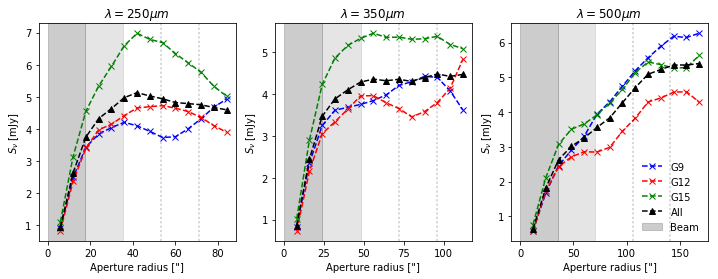

In [36]:
ph_mean = []
ph_mean2 = []
cols = {'G9':'b', 'G12':'r', 'G15':'g'}
j=1
zbin = 0
rmax=14

fig = plt.figure(figsize=(12,4))
for lambda_ in lambdas:
    plt.subplot(1,3,j)
    plt.title(r'$\lambda=%d \mu m$ ' %lambda_)
    
    for patch in patches:
        for i in xrange(1,rmax+1):
            ph_mean.append(GetPhotometryFromStacks(lambda_, zbin, patch, i, r_in=7*psf[lambda_]/reso[lambda_], r_out=9*psf[lambda_]/reso[lambda_], remove_mean=False, remove_max=10))
        plt.plot(reso[lambda_]*np.arange(1,rmax+1), ph_mean,'--x', label=patch, color=cols[patch])
        ph_mean = []
        ph_mean2 = []
          
    for i in xrange(1,rmax+1):
        print lambda_, i*reso[lambda_], i*2**0.5*reso[lambda_]
        ph_mean2.append(GetTotPhotometryFromStacks(lambda_, zbin, i, r_in=7*psf[lambda_]/reso[lambda_], r_out=9*psf[lambda_]/reso[lambda_], remove_mean=False, remove_max=10))
    
    plt.plot(reso[lambda_]*np.arange(1,rmax+1), ph_mean2,'--^', label='All', color='k')

    plt.axvspan(0, psf[lambda_], alpha=0.4, color='grey', label=r'Beam')
    plt.axvspan(psf[lambda_], 2*psf[lambda_], alpha=0.2, color='grey')
    plt.axvline(3*psf[lambda_], ls=':', alpha=0.2, color='k')
    plt.axvline(4*psf[lambda_], ls=':', alpha=0.2, color='k')
#     plt.ylim([0,12])
#     plt.xlim([0,100])
    plt.xlabel('Aperture radius ["]')
    plt.ylabel(r'$S_{\nu}$ [mJy]')
    j=j+1
plt.legend(loc='best',frameon=False)
    

In [64]:
def GetMedianPhotometryFromStacks(lambda_, zbin, patch, r, r_in=None, r_out=None, remove_mean=True, remove_max=0):
#     simuls = {}
#     simuls[patch] = sims[lambda_][patch][zbin].copy()
    simuls = sims[lambda_][patch][zbin].copy()

    if remove_max > 0:
        for _ in xrange(remove_max):
            simuls = np.delete(simuls, np.argmax(np.mean(simuls, axis=(1,2))), axis=0)
       
    if (r_in is None) or (r_out is None):
        apertures = CircularAperture(positions[lambda_], r=r)
        if remove_mean:
            stacked_map = (np.median(simuls,axis=0) - bkd[lambda_][patch][zbin].mean())
        else:
            stacked_map = np.median(simuls,axis=0)
        phot_table = aperture_photometry(stacked_map/(factor[lambda_])/1e-3, apertures)
    else:
        apertures = CircularAperture(positions[lambda_], r=r)
        annulus_apertures = CircularAnnulus(positions[lambda_], r_in=r_in, r_out=r_out)
        apers = [apertures, annulus_apertures]
        if remove_mean:
            stacked_map = (np.median(simuls,axis=0) - bkd[lambda_][patch][zbin].mean())
        else:
            stacked_map = np.median(simuls,axis=0)
        phot_table = aperture_photometry(stacked_map/(factor[lambda_])/1e-3, apers)  
        bkg_mean = phot_table['aperture_sum_1'] / annulus_apertures.area()
        bkg_sum = bkg_mean * apertures.area()
        final_sum = phot_table['aperture_sum_0'] - bkg_sum
        phot_table['aperture_sum'] = final_sum
    return phot_table.field('aperture_sum')[0]

In [73]:
bkd_

{'fluxes': array([ 39.74648909,   4.23826978,   5.02679758, ...,  32.2374641 ,
        -26.24858768, -37.23285969]),
 'lambda': 500,
 'maps': array([[ 0.00071225,  0.00074623,  0.00076365, ...,  0.00083754,
          0.00078089,  0.00081439],
        [ 0.0007776 ,  0.0006347 ,  0.000778  , ...,  0.00071256,
          0.00086882,  0.00056423],
        [ 0.00077449,  0.00077444,  0.00072396, ...,  0.00070239,
          0.00071734,  0.0007787 ],
        ..., 
        [ 0.00077449,  0.00074853,  0.00075013, ...,  0.00079805,
          0.00084634,  0.0008341 ],
        [ 0.00083948,  0.00058306,  0.00065448, ...,  0.00088409,
          0.00088494,  0.00085987],
        [ 0.00072245,  0.00061731,  0.00078907, ...,  0.00065184,
          0.00071313,  0.00082584]], dtype=float32),
 'noise': array([[ 0.01034058,  0.01031335,  0.01031621, ...,  0.01032082,
          0.01032899,  0.01031902],
        [ 0.01031955,  0.01032325,  0.01032227, ...,  0.01032383,
          0.01033401,  0.01032622],
   

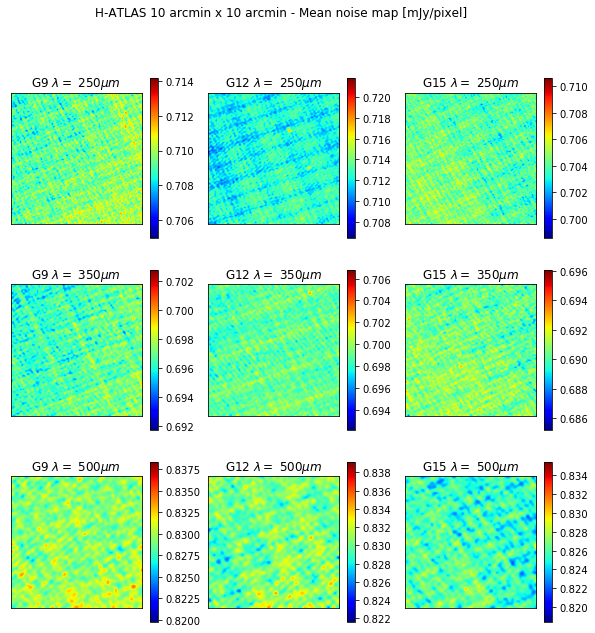

In [87]:
fig = plt.figure(figsize=(10,10))
i=1
plt.suptitle('H-ATLAS 10 arcmin x 10 arcmin - Mean noise map [mJy/pixel]')
for lambda_ in lambdas:
    for patch in patches:
        plt.subplot(3,3,i)
        plt.title(patch + r' $\lambda= $ ' +str(lambda_) + r'$\mu m$')
        plt.imshow(noise[lambda_][patch][0].mean(axis=0)/factor[lambda_]/1e-3, interpolation='bicubic', cmap='jet')
        plt.colorbar()
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_visible(False)
        frame1.axes.get_yaxis().set_visible(False)
        i += 1
plt.show()

In [82]:
noise[250]['G9'][0].mean(axis=0)

array([[ 0.00924665,  0.00922193,  0.00925201, ...,  0.00923854,
         0.0092451 ,  0.00924725],
       [ 0.0092454 ,  0.00924136,  0.00923013, ...,  0.00928745,
         0.00925099,  0.00923304],
       [ 0.00922806,  0.00925314,  0.00925104, ...,  0.00924214,
         0.00925894,  0.00924461],
       ..., 
       [ 0.00924285,  0.00922283,  0.00926455, ...,  0.00924355,
         0.00924045,  0.00926786],
       [ 0.00925763,  0.00923584,  0.00925423, ...,  0.00923451,
         0.00925501,  0.00924678],
       [ 0.0092458 ,  0.00925632,  0.00922991, ...,  0.00924275,
         0.00925469,  0.00924883]], dtype=float32)

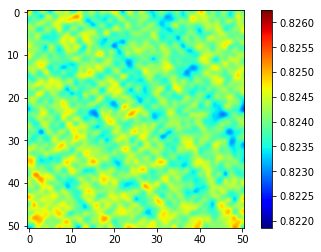

In [90]:
plt.imshow(bkd_['noise']/factor[500]/1e-3, interpolation='bicubic', cmap='jet')
plt.colorbar()